## Imports

In [1]:
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

#import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("vailable GPUs:", tf.config.list_physical_devices('GPU'))

In [2]:
!nvidia-smi

Tue Jun 17 14:08:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:01:00.0 Off |                    0 |
| N/A   50C    P0             28W /   70W |     418MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Checking GPU and CPU

In [2]:
print("Available CPUs:", os.cpu_count())
print("\n--------------------------\n")

if torch.cuda.is_available():
    print(f"Available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"{i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Available CPUs: 128

--------------------------

Available GPUs: 3
0: Tesla T4
1: Tesla T4
2: Tesla T4


## Functions

In [40]:
#####################################################
##################### Metrics #######################
#####################################################

def compute_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

#####################################################
#################### Checkpoint #####################
#####################################################

def save_checkpoint(model, optimizer, history, epoch, path='checkpoint.pth'):
    """Save model, optimizer state and history."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"[Checkpoint] Saved at epoch {epoch+1} → {path}")

def load_checkpoint(model, optimizer, path="checkpoint.pth", device='cpu'):
    """Load model, optimizer state, epoch and history from checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    history = checkpoint['history']
    print(f"[Checkpoint] Loaded from '{path}', resuming at epoch {start_epoch}.")
    return model, optimizer, start_epoch, history

#####################################################
###################### Train ########################
#####################################################

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.long().to(device)  # Para CrossEntropyLoss, labels devem ser long sem one-hot

        optimizer.zero_grad()
        outputs = model(images)  # logits, shape [batch, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * labels.size(0)
        batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

        running_loss += batch_loss
        running_corrects += batch_acc
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def evaluate_model(model, loader, criterion, device, desc="Evaluation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_loss = loss.item() * labels.size(0)
            batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

            running_loss += batch_loss
            running_corrects += batch_acc
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, start_epoch=0, history=None, 
                patience=5, checkpoint_path='checkpoint.pth', best_model_path='best_model.pth'):
    """Main training loop with checkpoint saving and early stopping."""

    if history is None:
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_time': []
        }

    best_val_loss = np.inf
    patience_counter = 0

    model.to(device)

    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, desc="Validation")

        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        # Checkpoint Save
        save_checkpoint(model, optimizer, history, epoch, path=checkpoint_path)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"[EarlyStopping] New best model saved (val_loss: {val_loss:.4f}) → {best_model_path}")
        else:
            patience_counter += 1
            print(f"[EarlyStopping] No improvement... ({patience_counter}/{patience} patience)")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time/60:.2f}min")

        if patience_counter >= patience:
            print(f"[EarlyStopping] Stopping early at epoch {epoch+1}.")
            break

    return history

#####################################################
###################### Evaluate #####################
#####################################################

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_on_test(model, test_loader, device, class_names=['class0', 'class1', 'class2', 'class3', 'class4']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # logits
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("\nTest Metrics:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1 Score:   {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds, normalize='pred')
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, cmap='Oranges', xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Split)')
    plt.tight_layout()
    plt.show()

#####################################################
####################### Plot ########################
#####################################################

def plot_training_history(history):
    sns.set(style='whitegrid')

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    sns.reset_defaults()

## Constants

In [20]:
if torch.cuda.is_available():
    torch.cuda.set_device(2) 
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

BATCH_SIZE = 16

cuda


## Data Processing

In [21]:
# Paths
data_dir = "../../dataset_multiclass"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),       # Resize image to fixed size
    transforms.RandomHorizontalFlip(),   # Randomly flip image horizontally (data augmentation)
    transforms.RandomVerticalFlip(),     # Randomly flip image vertically
    transforms.RandomRotation(15),       # Randomly rotate image ±15 degrees
    transforms.ColorJitter(               # Randomly change brightness, contrast, saturation, hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(              # Random affine transformations (rotation, translation, scale, shear)
        degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomResizedCrop(128),   # Crop random portion and resize to 128x128
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Validation and test transforms (no augmentation)
valid_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Datasets from image folders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=valid_test_transform)

custom_class_to_idx = {'Other Fruits': 0, 'Banana': 1}

# DataLoaders to load data in batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train set size: {len(train_dataset)} images")
print(f"Validation set size: {len(valid_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

Train set size: 9700 images
Validation set size: 200 images
Test set size: 100 images


In [22]:
from collections import Counter

def count_images_per_class(dataset, dataset_name):
    class_counts = Counter(dataset.targets)
    print(f"\n{dataset_name} - Number of images per class:")
    for idx, count in sorted(class_counts.items()):
        class_name = dataset.classes[idx]
        print(f"  Class {idx} ({class_name}): {count} images")

count_images_per_class(train_dataset, "Train")
count_images_per_class(valid_dataset, "Validation")
count_images_per_class(test_dataset, "Test")



Train - Number of images per class:
  Class 0 (Apple): 1940 images
  Class 1 (Banana): 1940 images
  Class 2 (Grape): 1940 images
  Class 3 (Mango): 1940 images
  Class 4 (Strawberry): 1940 images

Validation - Number of images per class:
  Class 0 (Apple): 40 images
  Class 1 (Banana): 40 images
  Class 2 (Grape): 40 images
  Class 3 (Mango): 40 images
  Class 4 (Strawberry): 40 images

Test - Number of images per class:
  Class 0 (Apple): 20 images
  Class 1 (Banana): 20 images
  Class 2 (Grape): 20 images
  Class 3 (Mango): 20 images
  Class 4 (Strawberry): 20 images


In [23]:
# Subsampling the datasets

from torch.utils.data import Subset
import numpy as np

def get_subset(dataset, fraction=0.1, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(dataset))
    subset_size = int(len(dataset) * fraction)
    subset_indices = indices[:subset_size]
    return Subset(dataset, subset_indices)

train_dataset_small = get_subset(train_dataset, fraction=0.01)
valid_dataset_small = get_subset(valid_dataset, fraction=1)
test_dataset_small = get_subset(test_dataset, fraction=1)

train_loader = DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_dataset_small, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset_small, batch_size=BATCH_SIZE)

print(f"Train set size: {len(train_dataset_small)} images")
print(f"Validation set size: {len(valid_dataset_small)} images")
print(f"Test set size: {len(test_dataset_small)} images")

Train set size: 97 images
Validation set size: 200 images
Test set size: 100 images


## Simple Model

In [24]:
# class SimpleBinaryCNN(nn.Module):
#     def __init__(self):
#         super(SimpleBinaryCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * 32 * 32, 128)
#         self.fc2 = nn.Linear(128, 1) 

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  
#         x = self.pool(F.relu(self.conv2(x)))  
#         x = x.view(-1, 32 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))  # [0,1]
#         return x

# class SimpleBinaryCNN(nn.Module):
#     def __init__(self):
#         super(SimpleBinaryCNN, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
#         # Pooling
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # Global Average Pooling to reduce size regardless of input dimensions
#         self.gap = nn.AdaptiveAvgPool2d((4, 4))  # Output shape: (batch, 64, 4, 4)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(64 * 4 * 4, 128)
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # -> (16, 64, 64)
#         x = self.pool(F.relu(self.conv2(x)))  # -> (32, 32, 32)
#         x = self.pool(F.relu(self.conv3(x)))  # -> (64, 16, 16)
#         x = self.gap(x)                        # -> (64, 4, 4)
#         x = x.view(x.size(0), -1)              # Flatten
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))         # Binary output between 0 and 1
#         return x

class SimpleOneConvCNN(nn.Module):
    def __init__(self):
        super(SimpleOneConvCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(4, 4)  # maior pooling
        self.fc1 = nn.Linear(16 * 32 * 32, 128)  # menos parâmetros
        self.fc2 = nn.Linear(128, 5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = x.view(-1, 16 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
from torchsummary import summary

model = SimpleOneConvCNN().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
            Linear-3                  [-1, 128]       2,097,280
            Linear-4                    [-1, 5]             645
Total params: 2,098,373
Trainable params: 2,098,373
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 2.13
Params size (MB): 8.00
Estimated Total Size (MB): 10.32
----------------------------------------------------------------


## Training

In [27]:
model = SimpleOneConvCNN().to(device)

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10
PATIENCE = 5

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=CRITERION, 
    optimizer=OPTIMIZER,
    device=device,
    epochs=EPOCHS,
    patience=PATIENCE,
    checkpoint_path='checkpoint.pth',
    best_model_path='best_model.pth'
)


Epoch 1/10


[Checkpoint] Saved at epoch 1 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.8867) → best_model.pth
Train Loss: 1.7990, Train Acc: 0.2577, Val Loss: 1.8867, Val Acc: 0.2400, Time: 0.22min

Epoch 2/10


[Checkpoint] Saved at epoch 2 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.6168) → best_model.pth
Train Loss: 1.7367, Train Acc: 0.2062, Val Loss: 1.6168, Val Acc: 0.2900, Time: 0.01min

Epoch 3/10


[Checkpoint] Saved at epoch 3 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.5327) → best_model.pth
Train Loss: 1.5659, Train Acc: 0.3093, Val Loss: 1.5327, Val Acc: 0.3500, Time: 0.08min

Epoch 4/10


[Checkpoint] Saved at epoch 4 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.5300) → best_model.pth
Train Loss: 1.5911, Train Acc: 0.2577, Val Loss: 1.5300, Val Acc: 0.3350, Time: 0.01min

Epoch 5/10


[Checkpoint] Saved at epoch 5 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.5614, Train Acc: 0.2577, Val Loss: 1.5713, Val Acc: 0.2900, Time: 0.15min

Epoch 6/10


[Checkpoint] Saved at epoch 6 → checkpoint.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 1.4816, Train Acc: 0.3608, Val Loss: 1.5745, Val Acc: 0.3000, Time: 0.01min

Epoch 7/10


[Checkpoint] Saved at epoch 7 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.4742) → best_model.pth
Train Loss: 1.5361, Train Acc: 0.3093, Val Loss: 1.4742, Val Acc: 0.3500, Time: 0.01min

Epoch 8/10


[Checkpoint] Saved at epoch 8 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.4316, Train Acc: 0.3608, Val Loss: 1.5730, Val Acc: 0.3350, Time: 0.01min

Epoch 9/10


[Checkpoint] Saved at epoch 9 → checkpoint.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 1.5522, Train Acc: 0.2990, Val Loss: 1.5186, Val Acc: 0.3450, Time: 0.01min

Epoch 10/10


[Checkpoint] Saved at epoch 10 → checkpoint.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 1.4212, Train Acc: 0.3711, Val Loss: 1.4917, Val Acc: 0.3600, Time: 0.01min


In [24]:
model, optimizer, start_epoch, history = load_checkpoint(model, OPTIMIZER, path='checkpoint.pth', device=device)

[Checkpoint] Loaded from 'checkpoint.pth', resuming at epoch 6.


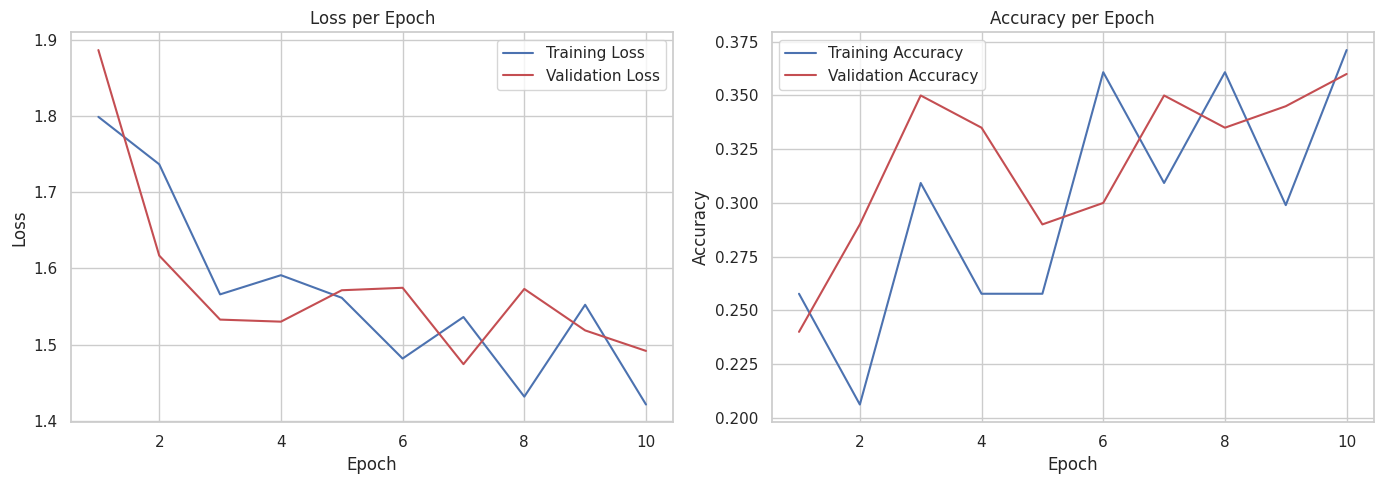

In [28]:
plot_training_history(history)


Test Metrics:
Accuracy:   0.3900
Precision:  0.5201
Recall:     0.3900
F1 Score:   0.3597

Classification Report:
              precision    recall  f1-score   support

       Apple     0.3333    0.1000    0.1538        20
      Banana     1.0000    0.1500    0.2609        20
       Grape     0.6471    0.5500    0.5946        20
       Mango     0.3077    0.4000    0.3478        20
  Strawberry     0.3125    0.7500    0.4412        20

    accuracy                         0.3900       100
   macro avg     0.5201    0.3900    0.3597       100
weighted avg     0.5201    0.3900    0.3597       100



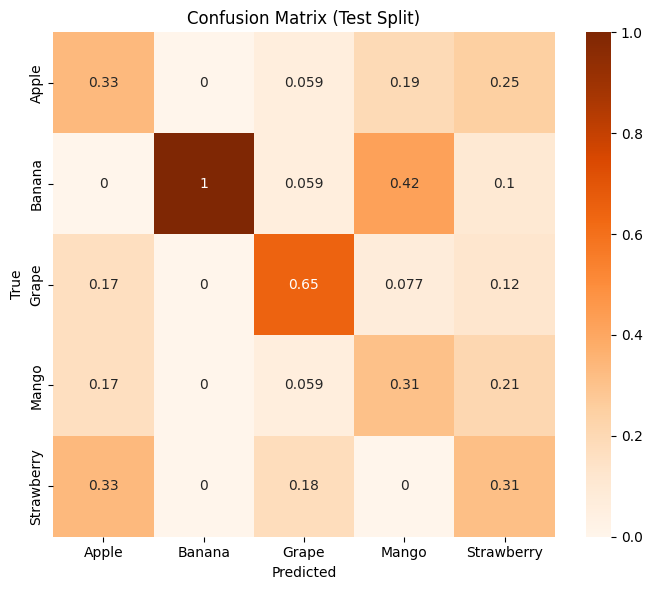

In [42]:
evaluate_on_test(model, test_loader, device=device, class_names=train_dataset.classes)

In [36]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_random_test_predictions(model, test_loader, device, class_names):
    model.eval()
    samples = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)  # logits [batch, num_classes]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            for img, true, pred in zip(images.cpu(), labels, preds):
                samples.append((img, true, pred))

    num_samples = min(12, len(samples))
    selected_samples = random.sample(samples, num_samples)

    plt.figure(figsize=(12, 9))
    for i, (img, true, pred) in enumerate(selected_samples):
        # img tensor shape: [C, H, W]
        image = img.numpy().transpose(1, 2, 0)  # [C,H,W] → [H,W,C]
        image = (image * 0.5) + 0.5  # Unnormalize assuming normalization (-1,1) to (0,1)
        image = np.clip(image, 0, 1)

        plt.subplot(3, 4, i + 1)
        plt.imshow(image)
        true_class = class_names[true]
        pred_class = class_names[pred]
        color = 'green' if true == pred else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


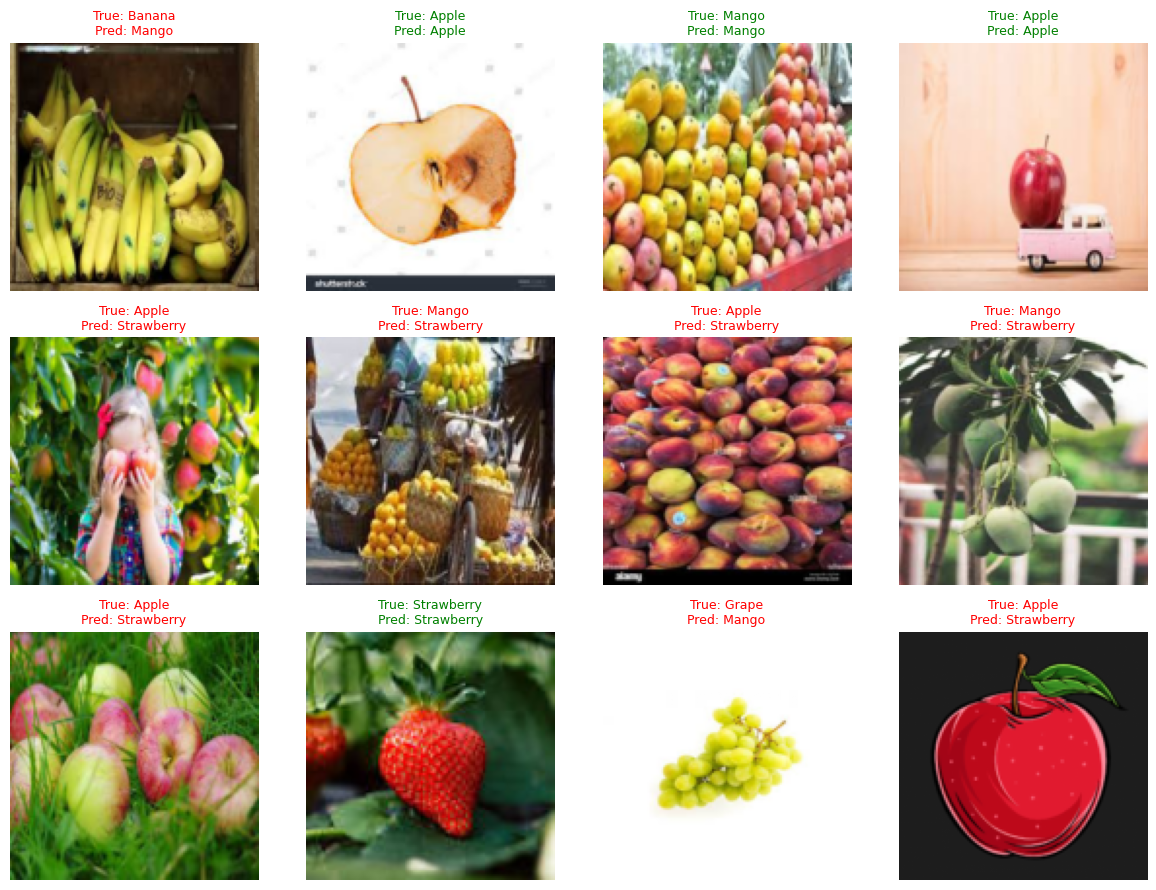

In [41]:
show_random_test_predictions(model, test_loader, device, class_names=train_dataset.classes)